# TWAS FUSION for one gene ENSG00000153814 (JAZF1) with 36 tissues

## Extraction of data 
Done locally to extract the data for each tissues and transformed them into plink trio 

In [1]:
dat = readRDS("~//ENSG00000153814.11.GTEx_V8.rds")

dat$X%>%colnames()

bim = dat$X%>%colnames()

bim = read.table( text = bim, sep = "_")
bim$V1 = 7
bim = bim%>%mutate(name = dat$X%>%colnames(), zero = 0  )%>%select(V1,name,zero,V2,V3,V4)
colnames(bim) = c("chr","id","posg","pos","ref","alt")
install.packages("genio")
library("genio")

output_path_pre = paste("~/Project/one_gene/")
output_path_named = paste("/cache/GTEx_V8.ENSG00000153814.11")

working = tibble(tissue = y)
working = working%>%filter(!str_detect(tissue,"Brain"))
working = working%>%mutate(
  fam = map(tissue, ~dat$y[[which(names(dat$y) == .x )]]%>%as_tibble(rownames = "fam_ID")%>%mutate(sample_ID = fam_ID,V2 = 0, V3 = 0, V4 = 0)%>%select("fam" = fam_ID, "id" = sample_ID, "pat" = V2, "mat" = V3, "sex" = V4,"pheno" = V1)),
  fam_sample = map(fam,~.x$fam),
  bed_prime = map(fam_sample, ~dat$X%>%as_tibble(rownames = NA)%>%filter(rownames(dat$X%>%as_tibble(rownames = NA)) %in% .x ))
  
  )


working = working%>%mutate(bed = map(bed_prime,~.x%>%as.matrix(rownames.force = TRUE)%>%t()))
working = working%>%mutate(output_path = map_chr(tissue, ~paste(c(output_path_pre,.x,output_path_named),collapse = "") ))

working%>%mutate(output = pmap(list(bed,fam,output_path),function(first,second,third) write_plink(third, first, bim = bim, fam = second) ) )
working$tissue%>%as_tibble()%>%write_delim("~/tissue.out",delim = "\t")


Warning message in gzfile(file, "rb"):
“cannot open compressed file '/home/hs3163/Downloads/ENSG00000153814.11.GTEx_V8.rds', probable reason 'No such file or directory'”


ERROR: Error in gzfile(file, "rb"): cannot open the connection


ERROR: Error in eval(expr, envir, enclos): object 'dat' not found


## Make needed file
Done on the cluster.

In [ ]:


cd ~/Project/one_gene
for i in `ls` ; do 
touch one_gene/$i/cache/GTEx_V8.ENSG00000153814.exp 
touch one_gene/$i/cache/GTEx_V8.ENSG00000153814.pheno ; done
head /home/hs3163/Project/Alz/data/RSM_Alz_region_list_DLPFC.txt > rg_ls
cat /home/hs3163/Project/Alz/data/RSM_Alz_region_list_DLPFC.txt | grep ENSG00000153814 >> rg_ls
tail -36 tissue.out > tissue.out



cd ~/Project/one_gene
for i in `cat ~/Project/one_gene/passed_tissue` ; do echo ~/Project/one_gene/$i/ ; done




## Command to run fusion for each genes

In [ ]:


for tissue in `cat ~/Project/one_gene/passed_tissue`; do
cd $tissue
nohup sos run ~/GIT/neuro-twas/workflow/twas_fusion.ipynb compute_wgt  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/one_gene/GTEx_V8.txt  \
  --wd /home/hs3163/Project/one_gene/$tissue/ \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/one_gene/GTEx_V8.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1 \
  --asso_mem "60G" -s build \
  -J 6 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml &
cd ..
done

  

for sumstat in `cat ~/Project/one_gene/data/sumstat_list`;do
    mkdir $sumstat
    cd $sumstat
    for tissue in `cat ~/Project/one_gene/passed_tissue`; do
    mkdir $tissue
    cd $tissue
    nohup sos run ~/GIT/neuro-twas/workflow/twas_fusion.ipynb association_test  \
    --gwas_sumstat /home/hs3163/Project/one_gene/data/$sumstat \
    --molecular-pheno  /home/hs3163/Project/one_gene/GTEx_V8.txt  \
    --wd /home/hs3163/Project/one_gene/$sumstat/$tissue/ \
    --weights_path /home/hs3163/Project/one_gene/$tissue/WEIGHTS \
    --genotype_list /home/hs3163/Project/one_gene/data/geno_list \
    --region_list /home/hs3163/Project/one_gene/GTEx_V8.txt \
    --region_name 1 \
    --data_start 2 \
    --window 500000 \
    --container /mnt/mfs/statgen/containers/twas_latest.sif \
    --model bslmm blup lasso top1 enet \
    --job_size 1  -s build\
    --max_impute 1 \
    --asso_mem "60G" \
    -J 6 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml &
    cd .. ;
    done
    cd ..;
    done

## Analysis of estimated weights

In [2]:
library(dplyr)
library(readr)
library(tibble)
library(ggplot2)
library(purrr)
library(tidyr)
library("ggpubr")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:tidyr’:

    extract


The following object is masked from ‘package:purrr’:

    set_names




In [2]:
dir = "/home/hs3163/Project/one_gene/" 
tissue = read_delim("/home/hs3163/Project/one_gene/passed_tissue",delim = "\t",col_names = F )
Asthma.sumstat = read_delim("/home/hs3163/Project/one_gene/data/Asthma.sumstat",delim = "\t" )

bim = read_delim("~/Project/one_gene/data/GTEx.ref.bim",delim= "\t",col_names = F)
Mark_1 = "chr7_27868489_C_A_b38"
Mark_2 = "chr7_28274005_C_A_b38"


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  CHR = col_double(),
  POS = col_double(),
  REF = col_character(),
  ALT = col_character(),
  SNP = col_character(),
  BETA = col_double(),
  SE = col_double(),
  P = col_double(),
  cood38 = col_double(),
  cood37 = col_double(),
  qc = col_double(),
  Dif = col_double(),
  SNP_new = col_character(),
  A1 = col_character(),
  A2 = col_character(),
  Z = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_double(),
  X2 = col_character(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_character(),
  X6 = col_character()
)




In [8]:
bim$X2%>%as.tibble()%>%write_delim("~/JAZF1_SNP",delim = "\t")

In [254]:
overlapped = intersect(Asthma.sumstat$X3,bim$X4)
Asthma.sumstat%>%filter(X3%in% overlapped)
bim%>%filter(X4%in% overlapped)
overlap_snv = tibble(
UKB_id = Asthma.sumstat%>%filter(X3%in% overlapped)%>%pull(X11),
UKB_ref= Asthma.sumstat%>%filter(X3%in% overlapped)%>%pull(X4),
UKB_alt= Asthma.sumstat%>%filter(X3%in% overlapped)%>%pull(X5),
GTEX_id= bim%>%filter(X2%in% overlapped),
GTEX_ref= bim%>%filter(X5%in% overlapped),
GTEX_alt= bim%>%filter(X6%in% overlapped)
)

Warning message:
“Unknown or uninitialised column: `X3`.”


ERROR: Error: Problem with `filter()` input `..1`.
[34mℹ[39m Input `..1` is `X3 %in% overlapped`.
[31m✖[39m object 'X3' not found


In [250]:
overlap_snv = tibble(
UKB_id = Asthma.sumstat%>%filter(X3%in% overlapped)%>%pull(X11),
UKB_ref= Asthma.sumstat%>%filter(X3%in% overlapped)%>%pull(X4),
UKB_alt= Asthma.sumstat%>%filter(X3%in% overlapped)%>%pull(X5),
GTEX_id= bim%>%filter(X4%in% overlapped)%>%pull(X2),
GTEX_ref= bim%>%filter(X4%in% overlapped)%>%pull(X5),
GTEX_alt= bim%>%filter(X4%in% overlapped)%>%pull(X6)
)

ERROR: Error: Tibble columns must have compatible sizes.
* Size 150: Existing data.
* Size 151: Column `GTEX_id`.
[34mℹ[39m Only values of size one are recycled.


In [3]:
tissue = tissue%>%mutate(path = map_chr(X1,~paste(c(dir,.x,"/WEIGHTS/GTEx_V8.ENSG00000153814.wgt.RDat"),collapse = "" )),
                env = map(path,~attach(.x)),
                best_m = map_dbl(env,~which(.x$cv.performance[2,] == min(.x$cv.performance[2,]))%>%as.numeric)         
               )

The following objects are masked from file:/home/hs3163/Project/one_gene/Artery_Tibial/WEIGHTS/GTEx_V8.ENSG00000153814.wgt.RDat:

    cv.performance, hsq, hsq.pv, N.tot, snps, wgt.matrix


The following objects are masked from file:/home/hs3163/Project/one_gene/Liver/WEIGHTS/GTEx_V8.ENSG00000153814.wgt.RDat:

    cv.performance, hsq, hsq.pv, N.tot, snps, wgt.matrix


The following objects are masked from file:/home/hs3163/Project/one_gene/Artery_Tibial/WEIGHTS/GTEx_V8.ENSG00000153814.wgt.RDat:

    cv.performance, hsq, hsq.pv, N.tot, snps, wgt.matrix


The following objects are masked from file:/home/hs3163/Project/one_gene/Lung/WEIGHTS/GTEx_V8.ENSG00000153814.wgt.RDat:

    cv.performance, hsq, hsq.pv, N.tot, snps, wgt.matrix


The following objects are masked from file:/home/hs3163/Project/one_gene/Liver/WEIGHTS/GTEx_V8.ENSG00000153814.wgt.RDat:

    cv.performance, hsq, hsq.pv, N.tot, snps, wgt.matrix


The following objects are masked from file:/home/hs3163/Project/one_gene/Artery_

In [4]:
data = tissue%>%mutate(Wgt_mtrix = map2(best_m,env,~.y$wgt.matrix[,.x]),
                         best_pval = map_dbl(env,~min(.x$cv.performance[2,])%>%as.numeric())
                        )

In [15]:
data$Wgt_mtrix[[1]]%>%length

[1] 32230

## Visualization of weight

In [24]:
vis_pos = data%>%mutate(tissue = X1,Wgt_mtrix = map(Wgt_mtrix, ~.x%>%as_tibble%>%mutate(pos = 1:32230)))%>%unnest(Wgt_mtrix)


Warning message:
“Removed 32230 rows containing missing values (geom_point).”


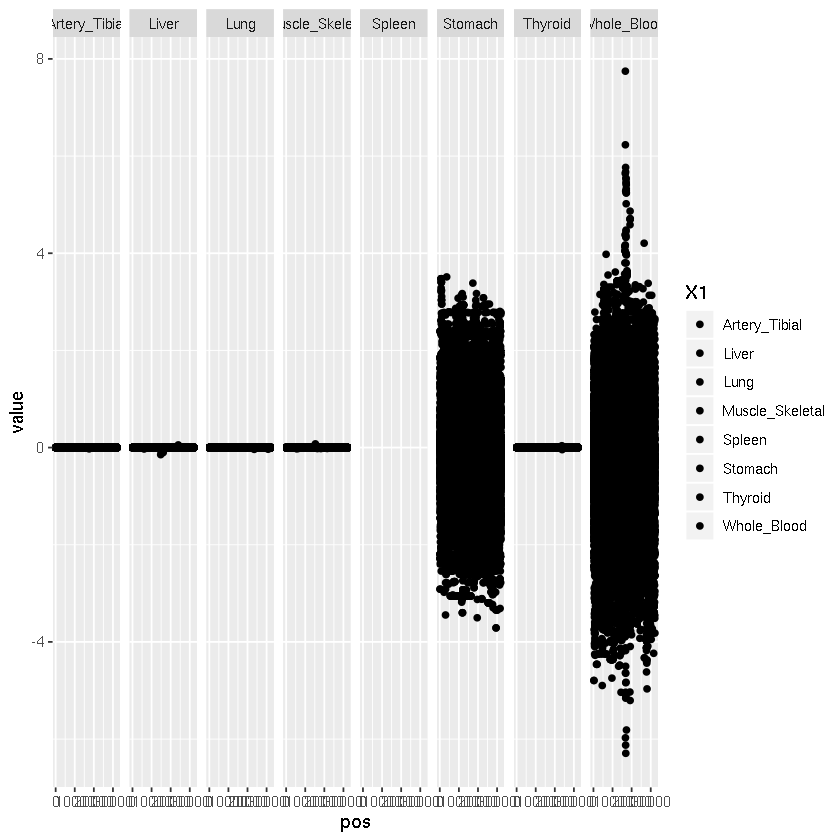

In [32]:
vis_pos%>%ggplot(aes(x = pos, y = value,fill = X1))+geom_point()+facet_grid(~tissue)

In [ ]:
vis_pos%>%filter()

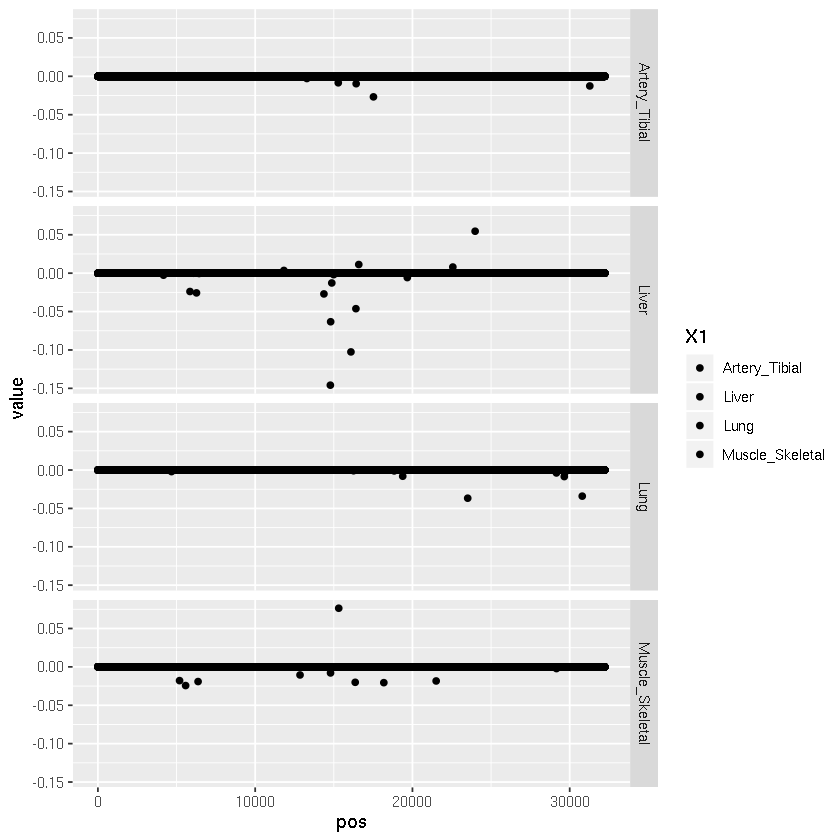

In [50]:
vis_pos%>%filter(X1 %in% c("Liver","Muscle_Skeletal","Lung","Artery_Tibial"))%>%ggplot(aes(x = pos, y = value,fill = X1))+geom_point()+facet_grid(rows = vars(tissue))

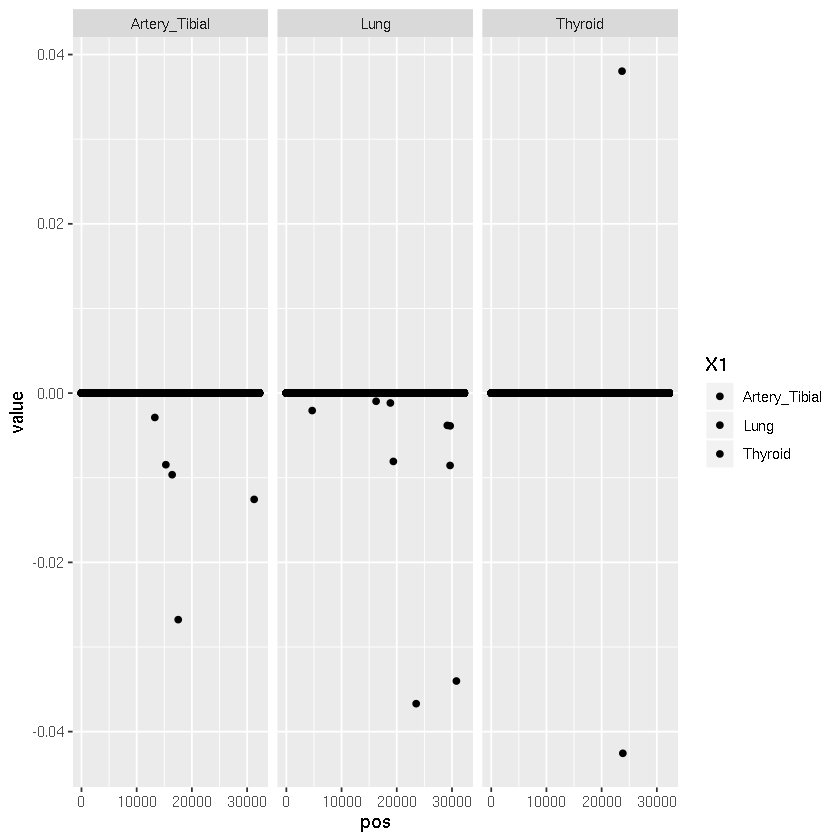

In [38]:
vis_pos%>%filter(!X1 %in% c("Liver","Muscle_Skeletal","Stomach","Whole_Blood","Spleen"))%>%ggplot(aes(x = pos, y = value,fill = X1))+geom_point()+facet_grid(~tissue)

In [141]:
data = data%>%mutate(v_whole = map_dbl(Wgt_mtrix,~.x%>%var() ),
                    region_1_mark = map_dbl(env,~which(.x$snps$V2 == Mark_1)),
                    region_2_mark = map_dbl(env,~which(.x$snps$V2 == Mark_2)),
                    Wgt_mtrix_region_1 = map2(Wgt_mtrix,region_1_mark,~.x[1:.y]),
                    Wgt_mtrix_region_2 = map2(Wgt_mtrix,region_2_mark,~.x[.y:length(.x)]),
                    Wgt_mtrix_overlap = pmap(list(Wgt_mtrix,region_1_mark,region_2_mark),function(first,second,third) first[(second+1):(third-1)]),
                     v_region_1 = map_dbl(Wgt_mtrix_region_1,~.x%>%var() ),
                     v_region_2 = map_dbl(Wgt_mtrix_region_2,~.x%>%var() ),
                     s_region_1 = map_dbl(Wgt_mtrix_region_1,~.x^2%>%sum() ),
                     s_region_2 = map_dbl(Wgt_mtrix_region_2,~.x^2%>%sum() ),
                     s_whole = map_dbl(Wgt_mtrix,~.x^2%>%sum() ),
                     s_overlap = map_dbl(Wgt_mtrix_overlap,~.x^2%>%sum() )
                    )

In [151]:
vis = data%>%select(X1,best_m,best_pval,s_whole,s_region_1,"s_region_3" = s_region_2,"s_region_2" = s_overlap)%>%mutate(sum =s_region_1 + s_region_2 + s_region_3 )

In [156]:
vis = vis%>%pivot_longer(cols =c("s_whole","s_region_1","s_region_2","s_region_3") ,names_to = "region", values_to = "sum_of_square", names_prefix = "s_")

In [175]:
data%>%select(X1,best_m,best_pval,s_whole,s_region_1,"s_region_3" = s_region_2,"s_region_2" = s_overlap)%>%mutate(sum =s_region_1 + s_region_2 + s_region_3 )

X1,best_m,best_pval,s_whole,s_region_1,s_region_3,s_region_2,sum
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Artery_Tibial,3,0.36542621,1.047274e-03,0.000000e+00,8.743264e-04,1.729478e-04,1.047274e-03
Liver,3,0.03346111,4.330034e-02,1.237488e-03,3.081815e-03,3.898104e-02,4.330034e-02
Lung,3,0.27695198,2.678634e-03,4.258074e-06,2.673446e-03,9.296026e-07,2.678634e-03
Muscle_Skeletal,3,0.02394978,8.454899e-03,1.277725e-03,7.645897e-04,6.412584e-03,8.454899e-03
Spleen,3,0.23607770,NA,NA,NA,NA,NA
Stomach,4,0.43275125,2.679138e+04,8.824762e+03,1.218241e+04,5.784214e+03,2.679138e+04
Thyroid,3,0.33383781,3.258497e-03,0.000000e+00,3.258497e-03,0.000000e+00,3.258497e-03
Whole_Blood,4,0.01092036,4.975442e+04,1.746660e+04,2.112348e+04,1.116434e+04,4.975442e+04


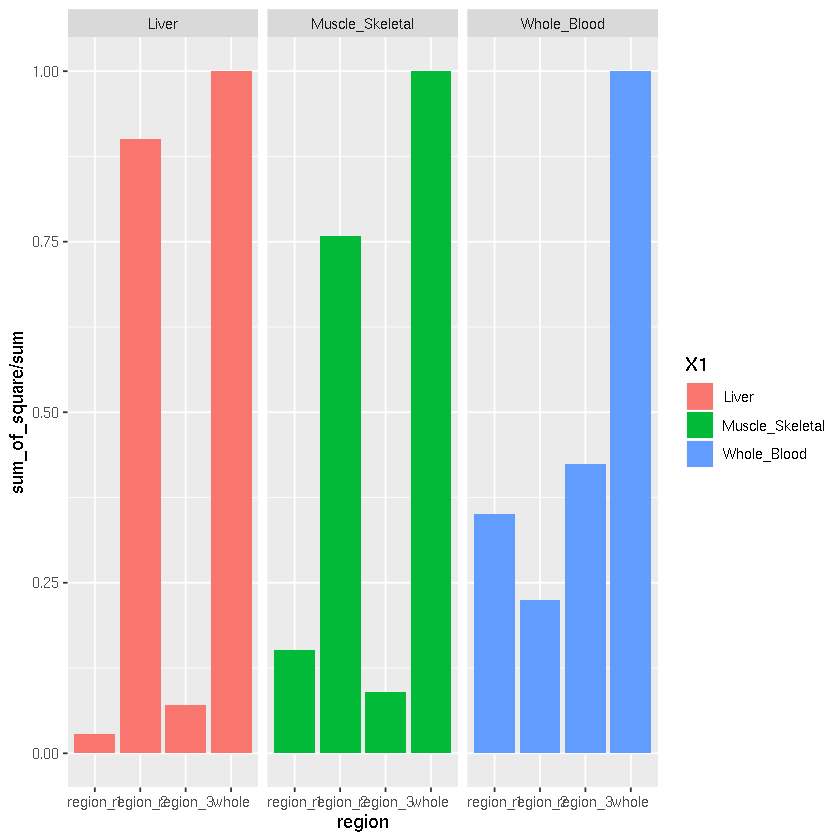

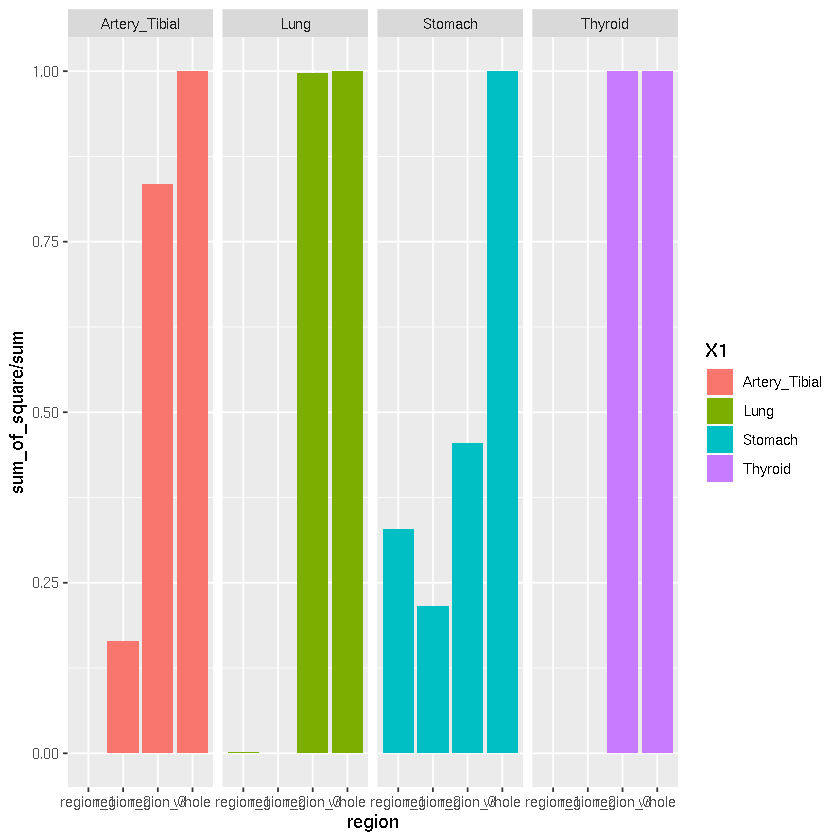

In [174]:
vis%>%filter(X1 %in% c("Liver","Muscle_Skeletal","Whole_Blood"))%>%ggplot(aes(x = region,y = sum_of_square/sum,fill = X1))+geom_col(position = "dodge")+facet_grid(~X1)
vis%>%filter(!X1 %in% c("Liver","Muscle_Skeletal","Whole_Blood","Spleen"))%>%ggplot(aes(x = region,y = sum_of_square/sum,fill = X1))+geom_col(position = "dodge")+facet_grid(~X1)


## Difference from Reference Genome

In [256]:
Asthma.sumstat%>%group_by(qc)%>%count

qc,n
<dbl>,<int>
-28,1
-24,1
-14,1
-11,1
-9,1
-8,2
-6,1
-5,2
-4,2


In [262]:
Asthma.sumstat%>%filter(qc == -28)
bim%>%filter(X2 == "chr7_28321666_C_CAT_b38")

X1,CHR,POS,REF,ALT,SNP,BETA,SE,P,cood38,cood37,qc,Dif,SNP_new,A1,A2,Z
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
6072235,7,28321666,CAT,C,chr7_28282019_C_CAT_b38,0.00178698,0.000939794,0.0572415,28282019,28321638,-28,-39647,chr7_28282019_C_CAT_b38,CAT,C,1.901459


X1,X2,X3,X4,X5,X6
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>


## TWAS result with FUSION

30000 variants where 20000 of them are imputed
Filter out rare variates, at mvsusie 
Mv Susie to get better estimates with extracted tissues from prior.

In [ ]:
phenotype = c("Asthma","diabetes","WAIST")
tissue = read_delim("~/Project/one_gene/passed_tissue",delim = "\t",col_names = F)$X1
working = tibble(tissue = rep(tissue,3))%>%mutate(phenotype = c(rep(phenotype[1],8),rep(phenotype[2],8),rep(phenotype[3],8)),
                                                 path = map2(phenotype,tissue,~paste(c("~/Project/one_gene/",.x,".sumstat/",.y,"/result/",.x,"_chr7.twas.txt"),collapse = "")),
                                                 data = map(path,~read_delim(.x,delim = "\t"))
                                                 )

In [288]:
working%>%select(-path)%>%unnest(data)%>%select(-c(FILE:P1),-BEST.GWAS.ID,-PANEL)%>%mutate(TWAS.P.Adj = p.adjust(TWAS.P))%>%filter(TWAS.P.Adj < 0.05)

tissue,phenotype,HSQ,BEST.GWAS.Z,EQTL.ID,EQTL.R2,EQTL.Z,EQTL.GWAS.Z,NSNP,NWGT,MODEL,MODELCV.R2,MODELCV.PV,TWAS.Z,TWAS.P,TWAS.P.Adj
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Liver,Asthma,0.603,7.4,chr7_28199847_A_G_b38,0.114000,-6.44,6.360,25248,22,lasso,0.180,0.033,-7.08,1.46e-12,2.920e-11
Muscle_Skeletal,Asthma,0.174,7.4,chr7_28149792_T_C_b38,0.036900,6.41,-4.720,25248,10,lasso,0.070,0.024,-4.29,1.81e-05,3.077e-04
Artery_Tibial,diabetes,0.107,-8.9,chr7_28220789_G_A_b38,-0.000609,-4.27,0.664,25248,4,lasso,0.013,0.370,-3.85,1.20e-04,1.800e-03
Liver,diabetes,0.603,-8.9,chr7_28199847_A_G_b38,0.114000,-6.44,5.170,25248,22,lasso,0.180,0.033,-4.79,1.69e-06,3.042e-05
Muscle_Skeletal,diabetes,0.174,-8.9,chr7_28149792_T_C_b38,0.036900,6.41,-8.560,25248,10,lasso,0.070,0.024,-7.06,1.63e-12,3.097e-11
Artery_Tibial,WAIST,0.107,-12.8,chr7_28220789_G_A_b38,-0.000609,-4.27,-1.250,25248,4,lasso,0.013,0.370,-4.13,3.68e-05,5.888e-04
Muscle_Skeletal,WAIST,0.174,-12.8,chr7_28149792_T_C_b38,0.036900,6.41,-12.300,25248,10,lasso,0.070,0.024,-8.20,2.38e-16,4.998e-15


In [284]:
result = working%>%select(-path)%>%unnest(data)%>%select(-c(FILE:P1))%>%mutate(TWAS.P.Adj = p.adjust(TWAS.P))
result%>%filter(MODELCV.PV < 0.05)

tissue,phenotype,PANEL,HSQ,BEST.GWAS.ID,BEST.GWAS.Z,EQTL.ID,EQTL.R2,EQTL.Z,EQTL.GWAS.Z,NSNP,NWGT,MODEL,MODELCV.R2,MODELCV.PV,TWAS.Z,TWAS.P,TWAS.P.Adj
<chr>,<chr>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Liver,Asthma,NA,0.603,chr7_28132967_T_C_b38,7.4,chr7_28199847_A_G_b38,0.1140,-6.44,6.360,25248,22,lasso,0.180,0.033,-7.080,1.46e-12,2.920e-11
Muscle_Skeletal,Asthma,NA,0.174,chr7_28132967_T_C_b38,7.4,chr7_28149792_T_C_b38,0.0369,6.41,-4.720,25248,10,lasso,0.070,0.024,-4.290,1.81e-05,3.077e-04
Whole_Blood,Asthma,NA,0.193,chr7_28132967_T_C_b38,7.4,chr7_28250210_C_T_b38,0.0821,-6.29,1.230,25248,1,top1,0.082,0.011,-1.230,2.20e-01,1.000e+00
Liver,diabetes,NA,0.603,chr7_28154778_C_A_b38,-8.9,chr7_28199847_A_G_b38,0.1140,-6.44,5.170,25248,22,lasso,0.180,0.033,-4.790,1.69e-06,3.042e-05
Muscle_Skeletal,diabetes,NA,0.174,chr7_28154778_C_A_b38,-8.9,chr7_28149792_T_C_b38,0.0369,6.41,-8.560,25248,10,lasso,0.070,0.024,-7.060,1.63e-12,3.097e-11
Whole_Blood,diabetes,NA,0.193,chr7_28154778_C_A_b38,-8.9,chr7_28250210_C_T_b38,0.0821,-6.29,-0.615,25248,1,top1,0.082,0.011,0.615,5.38e-01,1.000e+00
Liver,WAIST,NA,0.603,chr7_28165684_T_C_b38,-12.8,chr7_28199847_A_G_b38,0.1140,-6.44,1.340,25248,22,lasso,0.180,0.033,-1.100,2.72e-01,1.000e+00
Muscle_Skeletal,WAIST,NA,0.174,chr7_28165684_T_C_b38,-12.8,chr7_28149792_T_C_b38,0.0369,6.41,-12.300,25248,10,lasso,0.070,0.024,-8.200,2.38e-16,4.998e-15
Whole_Blood,WAIST,NA,0.193,chr7_28165684_T_C_b38,-12.8,chr7_28250210_C_T_b38,0.0821,-6.29,0.946,25248,1,top1,0.082,0.011,-0.946,3.44e-01,1.000e+00


In [289]:
result%>%filter(  )%>%select(-BEST.GWAS.ID)

tissue,phenotype,PANEL,HSQ,BEST.GWAS.Z,EQTL.ID,EQTL.R2,EQTL.Z,EQTL.GWAS.Z,NSNP,NWGT,MODEL,MODELCV.R2,MODELCV.PV,TWAS.Z,TWAS.P,TWAS.P.Adj
<chr>,<chr>,<lgl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Artery_Tibial,Asthma,NA,0.107,7.4,chr7_28220789_G_A_b38,-0.000609,-4.27,-0.0364,25248,4,lasso,0.0130,0.370,-0.7210,4.71e-01,1.000e+00
Liver,Asthma,NA,0.603,7.4,chr7_28199847_A_G_b38,0.114000,-6.44,6.3600,25248,22,lasso,0.1800,0.033,-7.0800,1.46e-12,2.920e-11
Lung,Asthma,NA,0.169,7.4,chr7_28993192_T_C_b38,0.005170,-4.38,0.0687,25248,6,lasso,0.0210,0.280,-1.0100,3.10e-01,1.000e+00
Muscle_Skeletal,Asthma,NA,0.174,7.4,chr7_28149792_T_C_b38,0.036900,6.41,-4.7200,25248,10,lasso,0.0700,0.024,-4.2900,1.81e-05,3.077e-04
Spleen,Asthma,NA,0.491,NA,NA,NA,NA,NA,0,0,lasso,0.0960,0.240,NA,NA,NA
Stomach,Asthma,NA,0.250,7.4,chr7_29009538_T_C_b38,0.003520,-3.71,0.1870,25248,1,top1,0.0035,0.430,-0.1870,8.52e-01,1.000e+00
Thyroid,Asthma,NA,0.189,7.4,chr7_28660950_C_T_b38,0.007190,-4.53,0.3310,25248,2,lasso,0.0110,0.330,-0.5070,6.12e-01,1.000e+00
Whole_Blood,Asthma,NA,0.193,7.4,chr7_28250210_C_T_b38,0.082100,-6.29,1.2300,25248,1,top1,0.0820,0.011,-1.2300,2.20e-01,1.000e+00
Artery_Tibial,diabetes,NA,0.107,-8.9,chr7_28220789_G_A_b38,-0.000609,-4.27,0.6640,25248,4,lasso,0.0130,0.370,-3.8500,1.20e-04,1.800e-03


## Uni SuSiE

In [ ]:
for tissue in `cat ~/Project/one_gene/passed_tissue`; do
mkdir $tissue
cd $tissue
nohup sos run ~/GIT/neuro-twas/workflow/uni_susie.ipynb susie_cv  \
  --molecular-pheno  /home/hs3163/Project/one_gene/GTEx_V8.txt  \
  --wd "/mnt/mfs/statgen/neuro-twas/JAZF1_uni_non/$tissue/" \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/one_gene/GTEx_V8.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --cv_times 100 \
  --job_size 1 \
  --MAF 0 \
  -s build \
  -J 6 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml &
cd ..
done



In [ ]:
for tissue in `cat ~/Project/one_gene/passed_tissue`; do
cp -r ~/Project/one_gene/$tissue ./JAZF1_uni/
done

for tissue in `cat ~/Project/one_gene/passed_tissue`; do
rm -r  ./JAZF1_uni_non/$tissue/susie
done




for tissue in `cat ~/Project/one_gene/passed_tissue`; do
cp -r  ./JAZF1_uni_non/$tissue/susie/GTEx_V8.ENSG00000153814.susie.model.cv.RData ./JAZF1_uni_non/$tissue/susie/GTEx_V8.ENSG00000153814.uni_weight.cv.RData
done


# MV SuSIE for JAZF1
## With filter out prior

In [ ]:
nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1/mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--cv_times 100 \
--mixture_prior '~/Project//one_gene/data/GTEx_V8_strong_z.ed_8tissue.rds' \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml  \
-s build &



nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb fusion_tf \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1/mole_pheno_ls_ft" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--cv_times 100 \
--mixture_prior '~/Project//one_gene/data/GTEx_V8_strong_z.ed_8tissue.rds' \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml  &

#### Filter out uncommon variants

nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb snp_exclude \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1/mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--cv_times 100 \
--mixture_prior '~/Project/one_gene/data/GTEx_V8_strong_z.ed_8tissue.rds' \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1/wgt/common_variant" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml  &


#### Association testing 

for sumstat in `cat ~/Project/one_gene/data/sumstat_list`;do
    mkdir $sumstat
    cd $sumstat
    for tissue in `cat ~/Project/one_gene/passed_tissue`; do
    mkdir $tissue
    cd $tissue
    nohup sos run ~/GIT/neuro-twas/workflow/twas_fusion.ipynb association_test  \
    --gwas_sumstat /home/hs3163/Project/one_gene/data/$sumstat \
    --molecular-pheno  /home/hs3163/Project/one_gene/GTEx_V8.txt  \
    --wd /mnt/mfs/statgen/neuro-twas/JAZF1/AT_result/$sumstat/$tissue/ \
    --weights_path /mnt/mfs/statgen/neuro-twas/JAZF1/wgt/$tissue/ \
    --weights_list /mnt/mfs/statgen/neuro-twas/JAZF1/wgt/$tissue/All_wgt_list.txt \
    --genotype_list /mnt/mfs/statgen/neuro-twas/JAZF1/geno_list \
    --region_list /home/hs3163/Project/one_gene/GTEx_V8.txt \
    --region_name 1 \
    --data_start 2 \
    --window 500000 \
    --container /mnt/mfs/statgen/containers/twas_latest.sif \
    --model bslmm blup lasso top1 enet \
    --job_size 1 \
    --max_impute 0.5 \
    --asso_mem "60G" \
    -J 6 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml &
    cd .. ;
    done
    cd ..;
    done

#### CV

nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1/mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--cv_times 100 \
--mixture_prior '~/Project//one_gene/data/GTEx_V8_strong_z.ed_8tissue.rds' \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml  \
-s build &


### TF for CVed data

nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb fusion_tf_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1/mole_pheno_ls_ft" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--cv_times 100 \
--mixture_prior '~/Project//one_gene/data/GTEx_V8_strong_z.ed_8tissue.rds' \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml  &

#### Association testing for CV dataset for consistancy

for sumstat in `cat ~/Project/one_gene/data/sumstat_list`;do
    mkdir $sumstat
    cd $sumstat
    for tissue in `cat ~/Project/one_gene/passed_tissue`; do
    mkdir $tissue
    cd $tissue
    nohup sos run ~/GIT/neuro-twas/workflow/twas_fusion.ipynb association_test  \
    --gwas_sumstat /home/hs3163/Project/one_gene/data/$sumstat \
    --molecular-pheno  /home/hs3163/Project/one_gene/GTEx_V8.txt  \
    --wd /mnt/mfs/statgen/neuro-twas/JAZF1/AT_result/$sumstat/$tissue/ \
    --weights_path /mnt/mfs/statgen/neuro-twas/JAZF1/wgt/$tissue/ \
    --weights_list /mnt/mfs/statgen/neuro-twas/JAZF1/wgt/$tissue/All_wgt_list.txt \
    --genotype_list /mnt/mfs/statgen/neuro-twas/JAZF1/geno_list \
    --region_list /home/hs3163/Project/one_gene/GTEx_V8.txt \
    --region_name 1 \
    --data_start 2 \
    --window 500000 \
    --container /mnt/mfs/statgen/containers/twas_latest.sif \
    --model bslmm blup lasso top1 enet \
    --job_size 1 \
    --max_impute 0.5 \
    --asso_mem "60G" \
    -J 6 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml &
    cd .. ;
    done
    cd ..;
    done





## With Default prior

In [ ]:

#### CV

nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1/mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1_default/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--cv_times 100 \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml  \
-s build &





## With teem

In [ ]:

#### CV

nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1/mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1_teem/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--mixture_prior '~/Project//one_gene/data/GTEx_V8_strong_z.teem_8tissue.rds' \
--cv_times 100 \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml  \
-s build &


### TF for CVed data

nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb fusion_tf_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1/mole_pheno_ls_ft" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--cv_times 100 \
--mixture_prior '~/Project//one_gene/data/GTEx_V8_strong_z.ed_8tissue.rds' \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml  &

#### Association testing for CV dataset for consistancy

for sumstat in `cat ~/Project/one_gene/data/sumstat_list`;do
    mkdir $sumstat
    cd $sumstat
    for tissue in `cat ~/Project/one_gene/passed_tissue`; do
    mkdir $tissue
    cd $tissue
    nohup sos run ~/GIT/neuro-twas/workflow/twas_fusion.ipynb association_test  \
    --gwas_sumstat /home/hs3163/Project/one_gene/data/$sumstat \
    --molecular-pheno  /home/hs3163/Project/one_gene/GTEx_V8.txt  \
    --wd /mnt/mfs/statgen/neuro-twas/JAZF1/AT_result/$sumstat/$tissue/ \
    --weights_path /mnt/mfs/statgen/neuro-twas/JAZF1/wgt/$tissue/ \
    --weights_list /mnt/mfs/statgen/neuro-twas/JAZF1/wgt/$tissue/All_wgt_list.txt \
    --genotype_list /mnt/mfs/statgen/neuro-twas/JAZF1/geno_list \
    --region_list /home/hs3163/Project/one_gene/GTEx_V8.txt \
    --region_name 1 \
    --data_start 2 \
    --window 500000 \
    --container /mnt/mfs/statgen/containers/twas_latest.sif \
    --model bslmm blup lasso top1 enet \
    --job_size 1 \
    --max_impute 0.5 \
    --asso_mem "60G" \
    -J 6 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml &
    cd .. ;
    done
    cd ..;
    done



## Selected tissues whose pip is significant predictor of Lung pip

In [ ]:

nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1_selected/mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1_selected//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1_selected/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--mixture_prior '~/Project//one_gene/data/GTEx_V8_strong_z.ed_selected_tissue.rds' \
--cv_times 100 \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1_selected/JAZF1_SNP" \
-J 200 -q neurology -c /home/hs3163/GIT/neuro-twas/code/csg.yml   &



## Selected tissues whose pip is significant predictor of Lung pip, Default

In [ ]:

nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1_selected_default//mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1_selected_default///region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1_selected_default//" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--cv_times 100 \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1_selected_default//JAZF1_SNP" \
-J 200 -q neurology -c /home/hs3163/GIT/neuro-twas/code/csg.yml   &



## 3 Tissue who have high cor in high weight factor

In [ ]:
nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1_3T//mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1_3T///region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1_3T//" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--mixture_prior '~/Project//one_gene/data/GTEx_V8_strong_z.ed_3_tissue.rds' \
--cv_times 100 \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1_3T//JAZF1_SNP" \
-J 200 -q neurology -c /home/hs3163/GIT/neuro-twas/code/csg.yml   &



## 3 Tissue who have high cor in high weight factor,Default

In [17]:
nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1_3T_Default///mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1_3T_Default////region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1_3T_Default///" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--cv_times 100 \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1_3T_Default///JAZF1_SNP" \
-J 200 -q neurology -c /home/hs3163/GIT/neuro-twas/code/csg.yml   &

ERROR: Error in parse(text = x, srcfile = src): <text>:1:7: unexpected symbol
1: nohup sos
          ^


## 5 Tissue

In [ ]:

#### CV

nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1_4ted/mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1_4ted//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1_4ted/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--mixture_prior '~/Project//one_gene/data/GTEx_V8_strong_z.ed_5tissue.rds' \
--cv_times 100 \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1_4ted/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml   &



## Hisample, common

In [ ]:
nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default//mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--cv_times 100 \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml   &



nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default_rare///mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default_rare//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default_rare/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--cv_times 100 \
--MAF 0.0015 \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_Default/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml   &

## Hisample, Rare,Prior

In [ ]:
nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_rare///mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_rare//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_rare/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--cv_times 100 \
--MAF 0.0015 \
--mixture_prior '~/Project//one_gene/data/GTEx_V8_strong_z.ed_hisample.rds' \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1_hisample_rare/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml   &

## Rare variants

In [ ]:
#### Rare Variant(Mod MVSuSiE cutoof to 0.0015 to allow maximum amount of variant while keep imputation under 50)

nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1_rare/mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1_rare//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1_rare/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--mixture_prior '~/Project//one_gene/data/GTEx_V8_strong_z.ed_8tissue.rds' \
--cv_times 100 \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1_rare/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml   &



nohup sos run /home/hs3163/GIT/neuro-twas/workflow/mv_susie.ipynb mv_susie_cv \
--molecular_pheno_dir "/mnt/mfs/statgen/neuro-twas/JAZF1_rare_default/mole_pheno_ls" \
--region_list "/mnt/mfs/statgen/neuro-twas/JAZF1_rare_default//region_list" \
--wd "/mnt/mfs/statgen/neuro-twas/JAZF1_rare_default/" \
--name_prefix "GTEx_V8" \
--container /mnt/mfs/statgen/containers/twas_latest.sif \
--impute TRUE --job_size 1 \
--cv_times 100 \
--extract_snp "/mnt/mfs/statgen/neuro-twas/JAZF1_rare/JAZF1_SNP" \
-J 200 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml   &






## Comparison of performance

In [3]:
t = attach("/mnt/mfs/statgen/neuro-twas/JAZF1_4ted/mv_cv.RData")


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_4ted/mv_cv.RData (pos = 4):

    output




In [ ]:
t$output

## TWAS result with MvSuSIE

In [55]:
intersect(Spleen$snps$V2,Asthma.sumstat$SNP)%>%length/length(Spleen$snps$V2)

[1] 0.8096414

In [ ]:
phenotype = c("Asthma","diabetes","WAIST")
tissue = read_delim("~/Project/one_gene/passed_tissue",delim = "\t",col_names = F)$X1
working = tibble(tissue = rep(tissue,3))%>%mutate(phenotype = c(rep(phenotype[1],8),rep(phenotype[2],8),rep(phenotype[3],8)),
                                                 path = map2(phenotype,tissue,~paste(c("/mnt/mfs/statgen/neuro-twas/JAZF1/AT_result/",.x,".sumstat/",.y,"/result/",.x,"_chr7.twas.txt"),collapse = "")),
                                                 data = map(path,~read_delim(.x,delim = "\t"))
                                                 )

In [40]:
result_mv = working%>%select(-path)%>%unnest(data)%>%select(-c(FILE:P1),-PANEL,-HSQ,-c(EQTL.ID:EQTL.GWAS.Z))%>%mutate(TWAS.P.Adj = p.adjust(TWAS.P))
result_mv%>%filter(TWAS.P.Adj < 0.05)

tissue,phenotype,BEST.GWAS.ID,BEST.GWAS.Z,NSNP,NWGT,MODEL,MODELCV.R2,MODELCV.PV,TWAS.Z,TWAS.P,TWAS.P.Adj
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Artery_Tibial,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,0.0095,0.34,-5.22,1.77e-07,3.3630e-06
Liver,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,0.0650,0.25,-7.28,3.22e-13,7.7280e-12
Lung,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,0.0110,0.35,-6.35,2.11e-10,4.2200e-09
Muscle_Skeletal,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,0.0320,0.13,-6.76,1.37e-11,3.0140e-10
Spleen,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,0.0290,0.33,-7.03,2.09e-12,4.8070e-11
Stomach,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,0.0041,0.42,-6.40,1.56e-10,3.2760e-09
Whole_Blood,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,0.0290,0.20,-4.79,1.65e-06,2.8050e-05
Artery_Tibial,diabetes,chr7_28154778_C_A_b38,-8.9,6083,6083,mv_susie,0.0095,0.34,-4.09,4.40e-05,5.2800e-04
Liver,diabetes,chr7_28154778_C_A_b38,-8.9,6083,6083,mv_susie,0.0650,0.25,-4.85,1.26e-06,2.2680e-05


tissue,old_pv,new_PV
<chr>,<dbl>,<dbl>
Artery_Tibial,0.34,0.3419
Liver,0.25,0.1974
Lung,0.35,0.3113
Muscle_Skeletal,0.13,0.0889
Spleen,0.33,0.3209
Stomach,0.42,0.5413
Thyroid,0.49,0.5242
Whole_Blood,0.20,0.1541


In [178]:
result_mv%>%filter(TWAS.P.Adj >= 0.05)

tissue,phenotype,BEST.GWAS.ID,BEST.GWAS.Z,NSNP,NWGT,MODEL,MODELCV.R2,MODELCV.PV,TWAS.Z,TWAS.P,TWAS.P.Adj
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Thyroid,Asthma,chr7_28132967_T_C_b38,7.4,6083,6083,mv_susie,-0.00013,0.49,-2.230,0.0257,0.2570
Thyroid,diabetes,chr7_28154778_C_A_b38,-8.9,6083,6083,mv_susie,-0.00013,0.49,-1.780,0.0746,0.4476
Artery_Tibial,WAIST,chr7_28165684_T_C_b38,12.8,6083,6083,mv_susie,0.00950,0.34,-1.660,0.0972,0.4775
Liver,WAIST,chr7_28165684_T_C_b38,12.8,6083,6083,mv_susie,0.06500,0.25,-2.000,0.0459,0.4131
Lung,WAIST,chr7_28165684_T_C_b38,12.8,6083,6083,mv_susie,0.01100,0.35,-1.480,0.1400,0.4775
Muscle_Skeletal,WAIST,chr7_28165684_T_C_b38,12.8,6083,6083,mv_susie,0.03200,0.13,-1.960,0.0498,0.4131
Spleen,WAIST,chr7_28165684_T_C_b38,12.8,6083,6083,mv_susie,0.02900,0.33,-1.980,0.0478,0.4131
Stomach,WAIST,chr7_28165684_T_C_b38,12.8,6083,6083,mv_susie,0.00410,0.42,-1.670,0.0955,0.4775
Thyroid,WAIST,chr7_28165684_T_C_b38,12.8,6083,6083,mv_susie,-0.00013,0.49,0.529,0.5970,1.0000


In [87]:
a = attach("/mnt/mfs/statgen/neuro-twas/JAZF1/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData")

a$full_model$sets$cs

The following object is masked _by_ .GlobalEnv:

    full_model


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData (pos = 3):

    full_model


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData (pos = 4):

    full_model


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData (pos = 5):

    full_model




[1] 6656

In [102]:
# Credible set
a$full_model$sets$cs
a$full_model$sets$purity
b = (a$full_model$sets$cs%>%unlist%>%as.numeric)

$L2
[1] 3818

$L1
 [1] 3442 3443 3446 3490 3497 3501 3503 3504 3506 3518 3522 3567 3576 3583 3690

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L2,1.000000,1.0000000,1.0000000
L1,0.517289,0.8099096,0.9046772


In [135]:
# The largest one
which(a$full_model$coef == a$full_model$coef%>%max())

a$full_model$coef%>%max()
# The largest one among the CS
a$full_model$coef[b,]%>%max()
# PIP
a$full_model$pip[3818]
a$full_model$pip%>%length
a$full_model$coef%>%

a$full_model$coef[,1]%>%max()
a$full_model$coef[,2]%>%max()
a$full_model$coef[,3]%>%max()
a$full_model$coef[,4]%>%max()
a$full_model$coef[,5]%>%max()
a$full_model$coef[,6]%>%max()
a$full_model$coef[,7]%>%max()
a$full_model$coef[,8]%>%max()

[1] 57698

[1] 0.2726163

[1] 0.0003133779

[1] 0.9998273

[1] 7696

[1] 0.005252827

[1] 0.003536806

[1] 0.03046519

[1] 0.004289947

[1] 0.1335541

[1] 0.04016323

[1] 9.728857e-05

[1] 0.2726163

In [173]:
colMax <- function(data) sapply(data, max, na.rm = TRUE)

abs = abs(a$full_model$coef)
max = colMax(abs%>%as_tibble)
max_id = which(abs[b+1,] %in% max)
max_id/16

[1] 0.3125 1.3125 2.3125 3.3125 7.0625

In [171]:
abs[b+1,][max_id]
which(max == abs[b+1,][49] )

[1] 0.01580753 0.09385141 0.03134290 0.04949112 0.27261632

named integer(0)

In [154]:
max = colMax(a$full_model$coef%>%as_tibble)
which(a$full_model$coef[b+1,] %in% max)


ERROR: Error in max(abs): invalid 'type' (builtin) of argument


In [176]:
a$full_model$intercept
a$full_model$coef[b+1,]

[1]  0.005252827 -0.067534820 -0.001469364 -0.002719458  0.133554129
[6]  0.040163231 -0.010329199  0.002714997

-0.0033449811,0.003536806,0.0304651874,0.004289947,0.047553736,-0.0011561946,-1.129280e-03,2.726163e-01
-0.0005811328,-0.007535368,-0.0023503357,-0.003911205,-0.003742955,-0.0011001927,-1.014839e-03,-8.378977e-04
-0.0002537522,-0.002777719,-0.0008214189,-0.001414708,-0.001375875,-0.0003823060,-3.682700e-04,-3.176568e-04
-0.0005811328,-0.007535368,-0.0023503357,-0.003911205,-0.003742955,-0.0011001927,-1.014839e-03,-8.378977e-04
-0.0158075337,-0.093851408,-0.0313429034,-0.049491116,-0.048357659,-0.0187167296,-2.756856e-03,-1.175838e-02
-0.0002340162,-0.003195166,-0.0009584611,-0.001611558,-0.001860321,-0.0005776536,-2.382729e-04,-3.561588e-04
-0.0111312011,-0.068766658,-0.0228543073,-0.036235014,-0.035371170,-0.0136150935,-1.788139e-03,-8.567266e-03
-0.0001904650,-0.002840859,-0.0008668316,-0.001449602,-0.001608756,-0.0005113562,-2.054617e-04,-2.952103e-04
-0.0111312011,-0.068766658,-0.0228543073,-0.036235014,-0.035371170,-0.0136150935,-1.788139e-03,-8.567266e-03
-0.0111312011,-0.068766658,-0.0228543073,-0.036235014,-0.035371170,-0.0136150935,-1.788139e-03,-8.567266e-03
-0.0001793232,-0.003183893,-0.0009247384,-0.001595308,-0.001667294,-0.0006431769,-3.806959e-04,-3.743553e-04


## Diag of CV

In [4]:
model = attach("/mnt/mfs/statgen/neuro-twas/JAZF1_rare/result/GTEx_V8.ENSG00000153814.mv_susie.model.RData")

In [6]:
model$m_ENSG00000153814$sets

,min.abs.corr,mean.abs.corr,median.abs.corr
,<dbl>,<dbl>,<dbl>
L2,1.000000,1.0000000,1.0000000
L1,0.517289,0.8743678,0.9158703


In [9]:
b = model$m_ENSG00000153814$sets$cs%>%unlist()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




ERROR: Error in library("plink2R"): there is no package called ‘plink2R’


In [31]:
b = model$m_ENSG00000153814$sets$cs%>%unlist()
colMax <- function(data) sapply(data, max, na.rm = TRUE)
abs = abs(model$m_ENSG00000153814$coef)
max = colMax(abs%>%as_tibble)
max_id = which(abs[b+1,] %in% max)
max_id/14


[1] 0.3571429 1.3571429 2.3571429 3.3571429 7.0714286


Call:
lm(formula = c(1, 2, NA, NA) ~ c(1, 2, 4, 3))

Residuals:
ALL 2 residuals are 0: no residual degrees of freedom!

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept)          0         NA      NA       NA
c(1, 2, 4, 3)        1         NA      NA       NA

Residual standard error: NaN on 0 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:      1,	Adjusted R-squared:    NaN 
F-statistic:   NaN on 1 and 0 DF,  p-value: NA


In [12]:


#molc_pheno
a = c(
'./Artery_Tibial/'
,'./Liver/'
,'./Lung/'
,'./Muscle_Skeletal/'
,'./Spleen/'
,'./Stomach/'
,'./Thyroid/'
,'./Whole_Blood/'

)

tibble( `#molc_pheno` = a )%>%write_delim("/mnt/mfs/statgen/neuro-twas/JAZF1/mole_pheno_ls_ft" , "\t")


In [ ]:
library("dplyr")
library("plink2R")
library("tibble")
library("readr")
library("purrr")
#Load the input
genos = read_plink('/mnt/mfs/statgen/neuro-twas/JAZF1/cache/GTEx_V8.ENSG00000153814.merged')
molecular_pheno = read_delim('/mnt/mfs/statgen/neuro-twas/JAZF1/mole_pheno_ls_ft',delim = '\t')
full_model = attach('/mnt/mfs/statgen/neuro-twas/JAZF1/result/GTEx_V8.ENSG00000153814.mv_susie.model.RData')$m_ENSG00000153814
X_dat = attach('/mnt/mfs/statgen/neuro-twas/JAZF1/result/GTEx_V8.ENSG00000153814.transformed_XY.RData')$scaled_ENSG00000153814
X_snps = colnames(X_dat[[1]])
#Get all the components
pval = NA
rsq = NA
hsq.pv = NA
N.tot = nrow(genos$bed)
cv.performance_tol = rbind(
rsq = rsq, 
pval = pval
)
## Filter out the snps that are not in the bim for consistancy
snps = genos$bim%>%filter(V2 %in% X_snps )

# Create output for each tissue saperately

for(i in 1:nrow(molecular_pheno) ){
wgt.matrix = full_model$coef[2:nrow(full_model$coef),i]%>%as.matrix()
hsq = full_model$hsq[i]
dir = "/mnt/mfs/statgen/neuro-twas/JAZF1/wgt/"
tis = read.table(text = molecular_pheno[[i,2]], sep = "/", as.is = TRUE)
tis = tis[[length(tis)]]
sur = "/GTEx_V8.ENSG00000153814.mv.wgt.RDat"
out = paste(collapse = "",c(dir,tis,sur))
cv.performance = cv.performance_tol
colnames(cv.performance) = "mv_susie"
# make the folders
cmd0 = paste(c("mkdir ",dir),collapse = "")
system(cmd0,ignore.stdout=TRUE,ignore.stderr=TRUE)
cmd1 = paste(c("mkdir ",dir,tis),collapse = "")
system(cmd1,ignore.stdout=TRUE,ignore.stderr=TRUE)
# save the files
save(
wgt.matrix,
snps,
cv.performance,
hsq, hsq.pv, N.tot,
file = out
)    }


In [4]:
library("dplyr")
library("tibble")
library("readr")
library("purrr")

In [5]:
molecular_pheno = read_delim('/mnt/mfs/statgen/neuro-twas/JAZF1/mole_pheno_ls_ft',delim = '\t')
full_model = attach('/mnt/mfs/statgen/neuro-twas/JAZF1/result/GTEx_V8.ENSG00000153814.mv_susie.model.RData')$m_ENSG00000153814
X_dat = attach('/mnt/mfs/statgen/neuro-twas/JAZF1/result/GTEx_V8.ENSG00000153814.transformed_XY.RData')$scaled_ENSG00000153814
X_snps = colnames(X_dat[[1]])


── Column specification ────────────────────────────────────────────────────────
cols(
  `#molc_pheno` = col_character()
)




In [7]:
snps = read_delim('/mnt/mfs/statgen/neuro-twas/JAZF1/JAZF1_SNP',delim = "\t",col_names = F)


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character()
)




In [9]:
pval = NA
rsq = NA
hsq.pv = NA
N.tot = nrow(snps)
cv.performance_tol = rbind(
rsq = rsq, 
pval = pval
)

In [12]:
for(i in 1:nrow(molecular_pheno) ){
wgt.matrix = full_model$coef[2:nrow(full_model$coef),i]%>%as.matrix()
hsq = full_model$hsq[i]
dir = "/mnt/mfs/statgen/neuro-twas/JAZF1/wgt/"
tis = read.table(text = molecular_pheno[[i,1]], sep = "/", as.is = TRUE)
tis = tis[[length(tis)]]
sur = "/GTEx_V8.ENSG00000153814.mv.wgt.RDat"
out = paste(collapse = "",c(dir,tis,sur))
cv.performance = cv.performance_tol
colnames(cv.performance) = "mv_susie"
# make the folders
cmd0 = paste(c("mkdir ",dir),collapse = "")
system(cmd0,ignore.stdout=TRUE,ignore.stderr=TRUE)
cmd1 = paste(c("mkdir ",dir,tis),collapse = "")
system(cmd1,ignore.stdout=TRUE,ignore.stderr=TRUE)
# save the files
save(
wgt.matrix,
snps,
cv.performance,
hsq, hsq.pv, N.tot,
file = out
)    }

In [16]:
tis = read.table(text = molecular_pheno[[i,1]], sep = "/", as.is = TRUE)

In [20]:
tis

V1,V2,V3
<chr>,<chr>,<lgl>
.,Whole_Blood,NA


## Performance analysis

In [42]:
teem = attach("/mnt/mfs//statgen/neuro-twas/JAZF1_teem/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData")
five_tissue_ed = attach("/mnt/mfs//statgen/neuro-twas/JAZF1_4ted//result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData")

The following object is masked from file:/mnt/mfs//statgen/neuro-twas/JAZF1_teem/result/GTEx_V8.ENSG00000153814.mv_susie.model.cv.RData:

    full_model




In [46]:
teem$full_model$pval
five_tissue_ed = five_tissue_ed$full_model$pval
five_tissue_ed = c(five_tissue_ed[1:4],NA,NA,NA,five_tissue_ed[5])

V1        V2        V3        V4        V5        V6        V7        V8 
0.3988174 0.2330179 0.3243281 0.1371815 0.2550134 0.4285940 0.4293474 0.1897497

V1        V2        V3        V4        V5 
0.3374289 0.2829178 0.3455457 0.1436286 0.1846613

In [56]:
tibble(tissue = result_mv$tissue[1:8], ed = result_mv$MODELCV.PV[1:8], default = c(0.3419,0.1974,0.3113,0.0889,0.3209,0.5413,0.5242,0.1541), teem = teem$full_model$pval , five_tissue_ed = five_tissue_ed )

tissue,ed,default,teem,five_tissue_ed
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Artery_Tibial,0.34,0.3419,0.3988174,0.3374289
Liver,0.25,0.1974,0.2330179,0.2829178
Lung,0.35,0.3113,0.3243281,0.3455457
Muscle_Skeletal,0.13,0.0889,0.1371815,0.1436286
Spleen,0.33,0.3209,0.2550134,NA
Stomach,0.42,0.5413,0.4285940,NA
Thyroid,0.49,0.5242,0.4293474,NA
Whole_Blood,0.20,0.1541,0.1897497,0.1846613


## Strongest signal

### Rare variants

In [58]:
model_rare = attach("/mnt/mfs/statgen/neuro-twas/JAZF1_rare/result/GTEx_V8.ENSG00000153814.mv_susie.model.RData")

The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_rare/result/GTEx_V8.ENSG00000153814.mv_susie.model.RData (pos = 12):

    m_ENSG00000153814




In [69]:
b = model_rare$m_ENSG00000153814$sets$cs%>%unlist()
colMax <- function(data) sapply(data, max, na.rm = TRUE)
abs = abs(model_rare$m_ENSG00000153814$coef)
max = colMax(abs%>%as_tibble)
max_id = which(abs[b+1,] %in% max)
max_id/14%>%ceiling()%>%round()

[1] 0.3571429 1.3571429 2.3571429 3.3571429 7.0714286

In [70]:
abs[b+1,]

0.0032497581,0.003528059,0.0304910579,0.004318398,0.047514093,0.0011112697,1.025125e-03,0.2727287794
0.0005343570,0.006508202,0.0020515634,0.003398921,0.003242896,0.0009654691,9.024378e-04,0.0007443365
0.0002413677,0.002493939,0.0007467614,0.001279077,0.001239504,0.0003497937,3.416384e-04,0.0002939020
0.0005343570,0.006508202,0.0020515634,0.003398921,0.003242896,0.0009654691,9.024378e-04,0.0007443365
0.0171860914,0.098184672,0.0332418128,0.052222620,0.050801854,0.0198823372,3.466986e-03,0.0127539628
0.0002039093,0.002612604,0.0007916902,0.001326286,0.001524547,0.0004777607,2.047947e-04,0.0002986442
0.0120396931,0.071431091,0.0240707209,0.037966447,0.036896643,0.0143646629,2.285306e-03,0.0092309060
0.0001624735,0.002269385,0.0006990208,0.001164934,0.001287921,0.0004131100,1.725881e-04,0.0002418058
0.0120396931,0.071431091,0.0240707209,0.037966447,0.036896643,0.0143646629,2.285306e-03,0.0092309060
0.0120396931,0.071431091,0.0240707209,0.037966447,0.036896643,0.0143646629,2.285306e-03,0.0092309060
0.0001469419,0.002438609,0.0007136996,0.001227474,0.001279414,0.0004964229,2.985336e-04,0.0002915051


### Common variants

In [65]:
model = attach("/mnt/mfs/statgen/neuro-twas/JAZF1/result/GTEx_V8.ENSG00000153814.mv_susie.model.RData")

The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_rare/result/GTEx_V8.ENSG00000153814.mv_susie.model.RData (pos = 3):

    m_ENSG00000153814


The following object is masked from file:/mnt/mfs/statgen/neuro-twas/JAZF1_rare/result/GTEx_V8.ENSG00000153814.mv_susie.model.RData (pos = 13):

    m_ENSG00000153814




In [71]:
b = model$m_ENSG00000153814$sets$cs%>%unlist()
colMax <- function(data) sapply(data, max, na.rm = TRUE)
abs = abs(model$m_ENSG00000153814$coef)
max = colMax(abs%>%as_tibble)
max_id = which(abs[b+1,] %in% max)
max_id/16%>%ceiling()

[1] 0.3125 1.3125 2.3125 3.3125 7.0625

In [81]:
max

V1         V2         V3         V4         V5         V6         V7 
0.01392986 0.09604130 0.03560129 0.03727865 0.13206925 0.03994308 0.01044731 
        V8 
0.27321309

In [73]:
abs[b+1,]

0.0033449811,0.003536806,0.0304651874,0.004289947,0.047553736,0.0011561946,1.129280e-03,2.726163e-01
0.0005811328,0.007535368,0.0023503357,0.003911205,0.003742955,0.0011001927,1.014839e-03,8.378977e-04
0.0002537522,0.002777719,0.0008214189,0.001414708,0.001375875,0.0003823060,3.682700e-04,3.176568e-04
0.0005811328,0.007535368,0.0023503357,0.003911205,0.003742955,0.0011001927,1.014839e-03,8.378977e-04
0.0158075337,0.093851408,0.0313429034,0.049491116,0.048357659,0.0187167296,2.756856e-03,1.175838e-02
0.0002340162,0.003195166,0.0009584611,0.001611558,0.001860321,0.0005776536,2.382729e-04,3.561588e-04
0.0111312011,0.068766658,0.0228543073,0.036235014,0.035371170,0.0136150935,1.788139e-03,8.567266e-03
0.0001904650,0.002840859,0.0008668316,0.001449602,0.001608756,0.0005113562,2.054617e-04,2.952103e-04
0.0111312011,0.068766658,0.0228543073,0.036235014,0.035371170,0.0136150935,1.788139e-03,8.567266e-03
0.0111312011,0.068766658,0.0228543073,0.036235014,0.035371170,0.0136150935,1.788139e-03,8.567266e-03
0.0001793232,0.003183893,0.0009247384,0.001595308,0.001667294,0.0006431769,3.806959e-04,3.743553e-04


## teem

In [80]:
b = teem$full_model$sets$cs%>%unlist()
colMax <- function(data) sapply(data, max, na.rm = TRUE)
abs = abs(teem$full_model$coef)
max = colMax(abs%>%as_tibble)
max_id = which(abs[b+1,] %in% max)
max_id/12%>%ceiling()

[1] 0.4166667 1.4166667 2.0833333 3.4166667 7.0833333

In [79]:
abs[b+1,]

0.0001108409,0.004335632,0.035601285,0.010668460,0.055550309,0.0007030809,0.0056345487,0.2732130852
0.0009963123,0.013983470,0.003384973,0.005345817,0.005491504,0.0016625074,0.0015276515,0.0009105434
0.0004409864,0.005448077,0.001251605,0.002032202,0.002117879,0.0006117234,0.0005815236,0.0003658045
0.0009963123,0.013983470,0.003384973,0.005345817,0.005491504,0.0016625074,0.0015276515,0.0009105434
0.0139298649,0.096041298,0.025371123,0.037278648,0.039623175,0.0150656230,0.0017401464,0.0068101672
0.0003205353,0.004752331,0.001125020,0.001780285,0.002218216,0.0006876114,0.0002710586,0.0002968789
0.0102275993,0.073093570,0.019177460,0.028323767,0.030083345,0.0114177164,0.0011422037,0.0051317492
0.0102275993,0.073093570,0.019177460,0.028323767,0.030083345,0.0114177164,0.0011422037,0.0051317492
0.0102275993,0.073093570,0.019177460,0.028323767,0.030083345,0.0114177164,0.0011422037,0.0051317492
0.0003338137,0.006327622,0.001446483,0.002353066,0.002638942,0.0009436389,0.0006038005,0.0004493030
0.0005259479,0.009918740,0.002288140,0.003757441,0.004155082,0.0014851929,0.0010100578,0.0007252766


## Selected

In [1]:
selected = attach("/mnt/mfs/statgen/neuro-twas/JAZF1_selected/result/GTEx_V8.ENSG00000153814.mv_susie.model.RData")

In [16]:
b = selected$m_ENSG00000153814$sets$cs%>%unlist()
colMax <- function(data) sapply(data, max, na.rm = TRUE)
abs = abs(selected$m_ENSG00000153814$coef)
max = colMax(abs%>%as_tibble)
max_id = which(abs[b+1,] %in% max)
max_id/11%>%ceiling()

[1] 0.3636364 1.3636364 2.3636364

In [5]:
abs[b+1,]

0.0004601462,0.006494869,0.002106867,0.003294993,0.0007935185
0.0004597414,0.005377274,0.001679724,0.002738092,0.0006434002
0.0004601462,0.006494869,0.002106867,0.003294993,0.0007935185
0.0127841613,0.080158132,0.028017059,0.043214903,0.0017233086
0.0009355391,0.014265387,0.004455967,0.008667486,0.0009399371
0.0007765198,0.006658158,0.002255186,0.003913047,0.0005221092
0.0109847626,0.071646735,0.024956037,0.038591405,0.0013228448
0.0005826416,0.009879643,0.003128583,0.005817693,0.0006286699
0.0109847626,0.071646735,0.024956037,0.038591405,0.0013228448
0.0109847626,0.071646735,0.024956037,0.038591405,0.0013228448
0.0071368243,0.047464749,0.018370258,0.018113682,0.0015677987


In [ ]:
nohup sos run ~/GIT/neuro-twas/workflow/mixture_prior.ipynb plot_U \
        --model_data '~/Project//one_gene/data/GTEx_V8_strong_z.ed_8tissue.rds'  \
        --name ""  \
        --container /mnt/mfs/statgen/containers/twas_latest.sif \
        --tol 0  \
        --cwd /home/hs3163/Project/one_gene/data/ \
        -J 50 -q neurology -c ~/GIT/neuro-twas/code/csg.yml -s build &

In [ ]:
nohup sos run ~/GIT/neuro-twas/workflow/mixture_prior.ipynb plot_U \
        --model_data '~/Project//one_gene/data/GTEx_V8_strong_z.ed_selected_tissue.rds'  \
        --name ""  \
        --container /mnt/mfs/statgen/containers/twas_latest.sif \
        --tol 0.1  \
        --cwd /home/hs3163/Project/one_gene/data/ \
        -J 50 -q neurology -c ~/GIT/neuro-twas/code/csg.yml -s build &

In [ ]:
nohup sos run ~/GIT/neuro-twas/workflow/mixture_prior.ipynb plot_U \
        --model_data '~/Project//one_gene/data/GTEx_V8_strong_z.ed.rds'  \
        --name ""  \
        --container /mnt/mfs/statgen/containers/twas_latest.sif \
        --tol 0.1  \
        --cwd /home/hs3163/Project/one_gene/data/ \
        -J 50 -q neurology -c ~/GIT/neuro-twas/code/csg.yml -s build &

## Redo FUSION analysis with Asthma SNPs

### Create subset genotype
LOG: due to an accident running the following command, the original GTEx_V8.ENSG00000153814

In [ ]:
for tissue in `cat ~/Project/one_gene/passed_tissue`; do
cp -r ./one_gene_reanalysis/$tissue/cache ./one_gene/$tissue/
done

In [ ]:
for tissue in `cat ~/Project/one_gene/passed_tissue`; do
cp -r ./one_gene/$tissue ./one_gene_reanalysis/
plink --bfile ./one_gene/$tissue/cache/GTEx_V8.ENSG00000153814 --make-bed --extract ./one_gene/data/Asthma_snps --out ./one_gene_reanalysis/$tissue/cache/GTEx_V8.ENSG00000153814
done

### Redo the analysis

In [ ]:
for tissue in `cat ~/Project/one_gene/passed_tissue`; do
cd $tissue
nohup sos run ~/GIT/neuro-twas/workflow/twas_fusion.ipynb compute_wgt  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/one_gene/GTEx_V8.txt  \
  --wd /home/hs3163/Project/one_gene_reanalysis/$tissue/ \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/one_gene/GTEx_V8.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1 \
  --asso_mem "60G" -s build \
  -J 6 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml &
cd ..
done

In [ ]:

for sumstat in `cat ~/Project/one_gene/data/sumstat_list`;do
    mkdir $sumstat
    cd $sumstat
    for tissue in `cat ~/Project/one_gene/passed_tissue`; do
    mkdir $tissue
    cd $tissue
    nohup sos run ~/GIT/neuro-twas/workflow/twas_fusion.ipynb association_test  \
    --gwas_sumstat /home/hs3163/Project/one_gene/data/$sumstat \
    --molecular-pheno  /home/hs3163/Project/one_gene/GTEx_V8.txt  \
    --wd /home/hs3163/Project/one_gene_reanalysis/$sumstat/$tissue/ \
    --weights_path /home/hs3163/Project/one_gene_reanalysis/$tissue/WEIGHTS \
    --genotype_list /home/hs3163/Project/one_gene/data/geno_list \
    --region_list /home/hs3163/Project/one_gene/GTEx_V8.txt \
    --region_name 1 \
    --data_start 2 \
    --window 500000 \
    --container /mnt/mfs/statgen/containers/twas_latest.sif \
    --model bslmm blup lasso top1 enet \
    --job_size 1  -s build\
    --max_impute 1 \
    --asso_mem "60G" \
    -J 6 -q csg -c /home/hs3163/GIT/neuro-twas/code/csg.yml &
    cd .. ;
    done
    cd ..;
    done